# Data Cleaning

In [1]:
import numpy as np
import tensorflow as tf
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.optimizers import Adam

In [2]:
tf.compat.v1.enable_eager_execution()

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
def find_min_max_dimensions(directory):
    max_height = 0
    max_width = 0
    min_height = float('inf')
    min_width = float('inf')

    # Loop through all files in the directory and its subdirectories
    for subdir, _, files in os.walk(directory):
        for file in files:
            if file.endswith(('.jpg', '.jpeg', '.png')):  # Check common image extensions
                img_path = os.path.join(subdir, file)
                height, width = get_image_dimensions(img_path)

                # Update max dimensions
                max_height = max(max_height, height)
                max_width = max(max_width, width)

                # Update min dimensions
                min_height = min(min_height, height)
                min_width = min(min_width, width)

    return min_height, min_width, max_height, max_width

In [ ]:
root_directory = 'drive/MyDrive/scans'
min_height, min_width, max_height, max_width = find_min_max_dimensions(root_directory)

print(f"Min Height: {min_height}, Min Width: {min_width}")
print(f"Max Height: {max_height}, Max Width: {max_width}")

Min Height: 310, Min Width: 190
Max Height: 719, Max Width: 1048


In [ ]:
def resize_and_pad_image(img_path, target_size=224):
    # Load the image
    img = tf.io.read_file(img_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.convert_image_dtype(img, dtype=tf.float32)

    # Calculate the aspect ratio and resize
    original_height, original_width, _ = img.shape
    aspect_ratio = original_width / original_height
    if original_width < original_height:
        new_width = target_size * aspect_ratio
        new_height = target_size
    else:
        new_height = target_size / aspect_ratio
        new_width = target_size
    img = tf.image.resize(img, [int(new_height), int(new_width)])

    # Pad to target size
    img = tf.image.resize_with_crop_or_pad(img, target_size, target_size)

    # Convert image to uint8 and encode to JPEG for saving
    img = tf.image.convert_image_dtype(img, dtype=tf.uint8)
    img_encoded = tf.image.encode_jpeg(img)
    return img_encoded

def process_and_save_images(source_directory, destination_directory, target_size=224):
    if not os.path.exists(destination_directory):
        os.makedirs(destination_directory)

    for subdir, _, files in os.walk(source_directory):
        for file in files:
            if file.endswith(('.jpg', '.jpeg', '.png')):
                # Construct full file path
                source_path = os.path.join(subdir, file)

                # Construct destination path
                relative_path = os.path.relpath(subdir, source_directory)
                dest_subdir = os.path.join(destination_directory, relative_path)
                dest_path = os.path.join(dest_subdir, file)

                # Ensure destination directory exists
                if not os.path.exists(dest_subdir):
                    os.makedirs(dest_subdir)

                # Process and save the image
                processed_img = resize_and_pad_image(source_path, target_size)
                tf.io.write_file(dest_path, processed_img)

                print(f"Processed and saved: {dest_path}")

In [ ]:
process_and_save_images("drive/MyDrive/scans", "drive/MyDrive/new_scans")

# Create Dataset

In [35]:
def load_image(img_path):
    img = tf.io.read_file(img_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.convert_image_dtype(img, dtype=tf.float32)  # Normalize to [0,1]
    return img

def load_mask(mask_path):
    mask = tf.io.read_file(mask_path)
    mask = tf.image.decode_jpeg(mask, channels=1)  # Grayscale
    mask = tf.image.convert_image_dtype(mask, dtype=tf.float32)  # Normalize to [0,1]
    mask = tf.math.round(mask)  # Binarize to 0 or 1 values
    return mask

def build_dataset_from_directory(directory):
    img_paths = []
    mask_paths = []
    labels = []

    # Mapping for classification labels
    label_mapping = {
        "benign": 0,
        "malignant": 1,
        "normal": 2
    }

    for category in ["benign", "malignant", "normal"]:
        img_category_dir = os.path.join(directory, category, "full")
        mask_category_dir = os.path.join(directory, category, "masks")

        img_files = [f for f in os.listdir(img_category_dir) if f.endswith(('.jpg', '.jpeg', '.png'))]

        for img_file in img_files:
          img_paths.append(os.path.join(img_category_dir, img_file))

          # Adjust the mask filename to match the naming convention
          mask_file = os.path.splitext(img_file)[0] + "_mask" + os.path.splitext(img_file)[1]

          mask_paths.append(os.path.join(mask_category_dir, mask_file))
          labels.append(label_mapping[category])

    # Convert to tf.data.Dataset
    image_dataset = tf.data.Dataset.from_tensor_slices(img_paths).map(load_image, num_parallel_calls=tf.data.AUTOTUNE)
    mask_dataset = tf.data.Dataset.from_tensor_slices(mask_paths).map(load_mask, num_parallel_calls=tf.data.AUTOTUNE)
    label_dataset = tf.data.Dataset.from_tensor_slices(labels)

    # Combine datasets such that the output is (image, (classification_label, mask_label))
    dataset = tf.data.Dataset.zip((image_dataset, tf.data.Dataset.zip((label_dataset, mask_dataset))))

    return dataset

# Usage
directory = "drive/MyDrive/new_scans"
dataset = build_dataset_from_directory(directory)
dataset

<_ZipDataset element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.float32, name=None), (TensorSpec(shape=(), dtype=tf.int32, name=None), TensorSpec(shape=(None, None, 1), dtype=tf.float32, name=None)))>

# Transfer Learning with MobileNetV2

In [36]:
from tensorflow.keras.applications import MobileNetV2

# Load MobileNetV2 without the top classification layer
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

In [41]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten, GlobalAveragePooling2D, UpSampling2D

MASK_SIZE = 28  # Adjust this value based on the desired down-sampled mask size

# Common layer for feature extraction
x = base_model.output
x = GlobalAveragePooling2D()(x)

# Task 1: Classification
classification_output = Dense(3, activation='softmax', name='classification_output')(x)

# Task 2: Mask prediction (downscale and then upscale)
# Downscale for mask prediction
x_mask_small = Flatten()(base_model.output)
mask_output_small = Dense(MASK_SIZE * MASK_SIZE, activation='sigmoid', name='mask_output_small')(x_mask_small)
mask_output_small = tf.keras.layers.Reshape((MASK_SIZE, MASK_SIZE, 1))(mask_output_small)

# Upscale the mask to the original size
mask_output = UpSampling2D(size=(224 // MASK_SIZE, 224 // MASK_SIZE), name='mask_output')(mask_output_small)

# Define the model
model = Model(inputs=base_model.input, outputs=[classification_output, mask_output])

# Freeze layers from the pre-trained model
for layer in base_model.layers:
    layer.trainable = False

In [42]:
losses = {
    'classification_output': 'sparse_categorical_crossentropy',
    'mask_output': 'binary_crossentropy'
}

loss_weights = {
    'classification_output': 1.0,
    'mask_output': 1.0
}

model.compile(optimizer='adam', loss=losses, loss_weights=loss_weights, metrics=['accuracy'])

In [43]:
dataset = dataset.shuffle(buffer_size=1000)
num_validation_samples = int(0.2 * 780)  # 20% of 780 images
num_training_samples = 780 - num_validation_samples

train_dataset = dataset.take(num_training_samples)
val_dataset = dataset.skip(num_training_samples)

batch_size = 32

train_dataset = train_dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)
val_dataset = val_dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)

In [44]:
epochs = 20
history = model.fit(train_dataset, validation_data=val_dataset, epochs=epochs)

Epoch 1/20
20/20 [==============================] - 6s 124ms/step - loss: 2.0187 - classification_output_loss: 1.1420 - mask_output_loss: 0.8767 - classification_output_accuracy: 0.5096 - mask_output_accuracy: 0.9146 - val_loss: 1.8519 - val_classification_output_loss: 0.8755 - val_mask_output_loss: 0.9764 - val_classification_output_accuracy: 0.5705 - val_mask_output_accuracy: 0.9323
Epoch 2/20
20/20 [==============================] - 2s 76ms/step - loss: 1.5901 - classification_output_loss: 0.7521 - mask_output_loss: 0.8380 - classification_output_accuracy: 0.6378 - mask_output_accuracy: 0.9418 - val_loss: 1.3773 - val_classification_output_loss: 0.6112 - val_mask_output_loss: 0.7661 - val_classification_output_accuracy: 0.7436 - val_mask_output_accuracy: 0.9472
Epoch 3/20
20/20 [==============================] - 2s 74ms/step - loss: 1.4733 - classification_output_loss: 0.6446 - mask_output_loss: 0.8287 - classification_output_accuracy: 0.7019 - mask_output_accuracy: 0.9433 - val_los

In [53]:
val_data = list(val_dataset.unbatch().as_numpy_iterator())
val_images = np.array([item[0] for item in val_data])
val_masks = np.array([item[1][1] for item in val_data])
val_labels = np.array([item[1][0] for item in val_data])

# Predict using the model
predicted_outputs = model.predict(val_images)
predicted_classifications = np.argmax(predicted_outputs[0], axis=1)

5/5 [==============================] - 0s 20ms/step


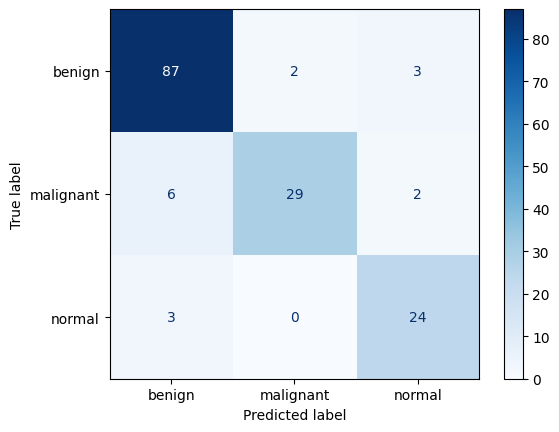

In [54]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

cm = confusion_matrix(val_labels, predicted_classifications)
classes = ["benign", "malignant", "normal"]
cm_display = ConfusionMatrixDisplay(cm, display_labels=classes).plot(cmap=plt.cm.Blues)

# Fine-tuning

In [55]:
# Unfreeze all layers of the base model or just some of them
for layer in base_model.layers:
    layer.trainable = True

# Use a smaller learning rate
optimizer = Adam(learning_rate=0.0001)

# Compile the model again
model.compile(optimizer=optimizer, loss=losses, loss_weights=loss_weights, metrics=['accuracy'])

# Continue training
additional_epochs = 5
history_finetune = model.fit(train_dataset, validation_data=val_dataset, epochs=additional_epochs)

Epoch 1/5
20/20 [==============================] - 29s 173ms/step - loss: 2.0752 - classification_output_loss: 1.2458 - mask_output_loss: 0.8294 - classification_output_accuracy: 0.6619 - mask_output_accuracy: 0.9389 - val_loss: 1.2233 - val_classification_output_loss: 0.4936 - val_mask_output_loss: 0.7297 - val_classification_output_accuracy: 0.7756 - val_mask_output_accuracy: 0.9503
Epoch 2/5
20/20 [==============================] - 3s 107ms/step - loss: 1.0550 - classification_output_loss: 0.2674 - mask_output_loss: 0.7876 - classification_output_accuracy: 0.8974 - mask_output_accuracy: 0.9419 - val_loss: 1.4323 - val_classification_output_loss: 0.6564 - val_mask_output_loss: 0.7760 - val_classification_output_accuracy: 0.7179 - val_mask_output_accuracy: 0.9473
Epoch 3/5
20/20 [==============================] - 3s 107ms/step - loss: 0.8778 - classification_output_loss: 0.0948 - mask_output_loss: 0.7830 - classification_output_accuracy: 0.9744 - mask_output_accuracy: 0.9435 - val_los

5/5 [==============================] - 1s 20ms/step


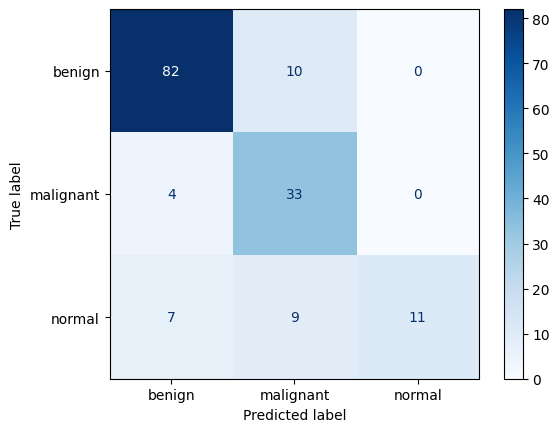

In [56]:
# Predict using the model
predicted_outputs = model.predict(val_images)
predicted_classifications = np.argmax(predicted_outputs[0], axis=1)
cm = confusion_matrix(val_labels, predicted_classifications)
classes = ["benign", "malignant", "normal"]
cm_display = ConfusionMatrixDisplay(cm, display_labels=classes).plot(cmap=plt.cm.Blues)